這裡開始已經假設你已經看過前面的所有基礎文件說明，因此多數註解會拿掉以維護版面乾淨

You Only Look Once，你只需要看一次，不需要先看框，再看類別，一次滿足檢測的所有需求。雖然已經有YOLOv4，但我們從YOLOv2重新來。

在下已有翻譯YOLOv2論文，也可以參閱[相關文件](在下已有翻譯LeNet-5論文，也可以參閱相關文件)，主要參考程式碼為[git_japap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0)

首先，我們要先取得資料集，會使用[Pascal VOC 2007的資料集](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html)，內有訓練、驗證、與測試三個子集。再請自行至上面連結內下載資料集即可。

解開tar之後，相關檔案會存在於資料夾VOCdevkit底下。不過就自己記得兩資料夾再解開，不然資料會混在一起。當然這個是看你介不介意，理論上是無所謂，因為文件內就有可以協助分離資料集的資料。

取得資料之後先認識一下資料

In [1]:
import os

In [2]:
path = '/tf/tf2/VOC2007/VOCdevkit/VOC2007'

In [3]:
os.listdir(path)

['JPEGImages',
 'ImageSets',
 'SegmentationObject',
 'SegmentationClass',
 'Annotations']

上面可以看的出來，資料集共有五個資料夾，其中的JPEGImages是比較直觀可以理解的，就是照片，我們拿Annotations裡面的一個文件來檢視

In [4]:
os.listdir(os.path.join(path, 'Annotations'))[0]

'004684.xml'

是個xml檔，因此我們就需要來parser這個xml看它裡面長什麼樣子，你可以直接parser這個xml，也可以轉dict，看個人，後面會以轉dict作業為主

In [5]:
import xml.etree.ElementTree as ET

In [6]:
tree = ET.ElementTree(file=os.path.join(path, 'Annotations', '005893.xml'))

In [7]:
for elem in tree.iter():
    print(elem.tag, elem.attrib, elem.text)

annotation {} 
	
folder {} VOC2007
filename {} 005893.jpg
source {} 
		
database {} The VOC2007 Database
annotation {} PASCAL VOC2007
image {} flickr
flickrid {} 321832155
owner {} 
		
flickrid {} kenny42952
name {} Kendrick Shackleford
size {} 
		
width {} 500
height {} 374
depth {} 3
segmented {} 0
object {} 
		
name {} train
pose {} Unspecified
truncated {} 1
difficult {} 0
bndbox {} 
			
xmin {} 1
ymin {} 84
xmax {} 479
ymax {} 182


把xml的結構print出來之後，有幾個比較重要的要先知道：
1. segmented: 是否用於分割
2. width: 照片的寬
3. height: 照片的高
4. depth: 照片的channel
5. name: 物件的類別
6. pose: 物件的姿勢
7. truncated: 照片是否被截斷
8. difficult: 是否難以辨識
9. xmin, ymin, xmax, ymax: bounding box左下、右上兩個點座標

如果照片上有多個物件，就會有多個object的tag，這部份可以再自行確認

下面我們拿這張照片出來驗證

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as img

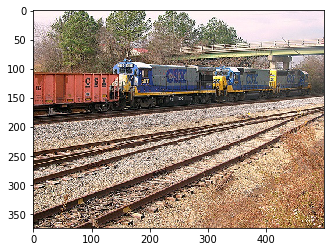

In [9]:
show_img = img.imread(os.path.join(path, 'JPEGImages', '005893.jpg'))
plt.imshow(show_img)
plt.show()

另一個需要注意的資料夾，就是ImageSets，這裡面Main的文件說明著你的資料集如何切分，其它的是用於其它的任務，後續有緣再來說明

In [10]:
os.listdir(os.path.join(path, 'ImageSets'))

['Layout', 'Main', 'Segmentation']

train、test、val三個資料集可以利用對應的三個文件來分割，因此上面才會說這資料混在一起也無所謂

In [11]:
with open(os.path.join(path, 'ImageSets', 'Main', 'train.txt')) as file:
    for f in file:
        print(f)
        break

000012



相關資料集說明至官方文件可以取得最清楚的說明，也提供一個不錯的簡中說明([arleyzhang](https://arleyzhang.github.io/articles/1dc20586/))給大家參考

現在，我們要開始處理資料集的資料整理問題，這部份其實有[現成的API](https://github.com/tensorflow/models/tree/master/research/object_detection)可以使用，但希望可以自己硬寫一發，這樣子可以更明白訓練所需的資料結構，這是模型架構之外另一個重要的議題

整個程式碼四處參考，列出參考來源：
1. [jmpap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0/blob/master/Yolo_V2_tf_2.ipynb)
2. [ying86615791](https://blog.csdn.net/ying86615791/article/details/102957513)

主要資料集的處理可以有兩種作法，一種是即時的取得資料，一種是將資料轉為tfrecord，首先我們來測試即時取得資料的方式。

我們知道，所有關於圖片的描述都在Annotations這資料夾內的xml裡面，因此我們要做的就是去解析這個xml，將這個xml弄成我們要的訓練資料格式

In [12]:
# 定義Annotations資料夾路徑
ann_folder = os.path.join(path, 'Annotations')

In [13]:
# 試著取得所有xml檔案
for ann in os.listdir(ann_folder):
    print(os.path.join(ann_folder, ann))
    break

/tf/tf2/VOC2007/VOCdevkit/VOC2007/Annotations/004684.xml


這邊我們可以先取單一檔案出來確認一下大致的檔案格式是怎麼樣，在那之前我們可以先試著將xml檔轉dict，看個人習慣，這可以利用xmltodict來處理，沒有的話就pip install xmltodict就可以了

我故意挑一個照片上有多個物件的xml檔來做範例，可以看的到object下有多個物件，後面我們在整理訓練資料的時候要注意到

In [14]:
import xmltodict
import numpy as np

In [15]:
f = open("/tf/tf2/VOC2007/VOCdevkit/VOC2007/Annotations/004686.xml", "r")
f_dict = xmltodict.parse(f.read(), force_list=True)['annotation']
f.close()

In [16]:
f_dict[0]

OrderedDict([('folder', ['VOC2007']),
             ('filename', ['004686.jpg']),
             ('source',
              [OrderedDict([('database', ['The VOC2007 Database']),
                            ('annotation', ['PASCAL VOC2007']),
                            ('image', ['flickr']),
                            ('flickrid', ['329940826'])])]),
             ('owner',
              [OrderedDict([('flickrid', ['Lothar Lenz']),
                            ('name', ['Lothar Lenz'])])]),
             ('size',
              [OrderedDict([('width', ['500']),
                            ('height', ['322']),
                            ('depth', ['3'])])]),
             ('segmented', ['0']),
             ('object',
              [OrderedDict([('name', ['horse']),
                            ('pose', ['Left']),
                            ('truncated', ['0']),
                            ('difficult', ['0']),
                            ('bndbox',
                             [OrderedDict([('x

我們會需要完整的影像資料夾名稱，因此先定義，後續結合使用

In [17]:
img_folder = os.path.join(path, 'JPEGImages')

然後我們要先設置一下label的對應，從上面的資料可以看的到，物件的名稱是以"文字"來描述，但我們無法直接使用文字，因此需要做轉換，這部份直接使用上面參考連結ying86615791的設置，可以看的到作者把很多的相同類型的東西做了大方向的分類

转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/ying86615791/java/article/details/102957513

In [18]:
VOC_NAME_LABEL_CLASS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

然後利用生成式直接產生對應表，這部份就不多說明

In [19]:
VOC_NAME_LABEL = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}
VOC_LABEL_NAME = {v[0]:key for key,v in VOC_NAME_LABEL_CLASS.items()}

現在我們要來試著取單筆的資料，因此迴圈內會加一個break來做為中斷點

In [20]:
# 是否處理難判斷的物件
# 要注意的是，如果後續你自己的資料集不打算有這個tag的話就不要設置處理
DIFFICULT = True 
# 記錄照片完全路徑
imgs_name = []
# 記錄照片的所有bound boxes
imgs_boxes = []
# 記錄一張照片多最多框有多少個
max_count = 0
# 取得資料筆數的flag，用於測試
i = 0
# 取得所有xml檔案
for ann in os.listdir(ann_folder):    
    # 用於記錄單張照片有幾個框
    bound_box_count = 0
    i += 1
    # 取讀檔案
    # print(f'now process: {os.path.join(ann_folder, ann)}')
    file = open(os.path.join(ann_folder, ann))
    dict_ann_data = xmltodict.parse(file.read(), force_list=True)['annotation'][0]
    file.close()
    # 開始處理資料格式
    # 這邊不做一些是否存在的判斷，直接假設你的資料都是符合資料格式
    # 記錄照片完整路徑
    imgs_name.append(os.path.join(img_folder, dict_ann_data["filename"][0]))
    # print(f'full path is: {os.path.join(img_folder, dict_ann_data["filename"][0])}')
    # 記錄照片的width、height
    w = int(dict_ann_data['size'][0]['width'][0])
    h = int(dict_ann_data['size'][0]['height'][0])
    # print(f'width: {w}, height: {h}')
    # 記錄照片中所有的物件資訊
    boxes = []
    
    # 判斷是否存在物件，有些照片可能只有背景
    # 不存在物件就直接解析下一個xml檔案
    if 'object' not in dict_ann_data:
        print('no object, pass!')
        continue       
    
    for obj in dict_ann_data['object']:
        bound_box_count += 1
        # 這邊加入一個是否處理難預測的照片，你也可以不要，看個人
        # 從上面的範例可以看的到，這邊檔案記錄的是字串0、1，因此需要轉型別         
        difficult = bool(int(obj['difficult'][0]))
        if difficult and DIFFICULT:
            continue
        # 記錄照片中物件的資訊
        # xmin、ymin、xmax、ymax、object label
        # 將座標做標準化是因為照片有大有小，而我們需要縮放至相同的大小
        # 才能一次批取資料，不然會報錯，因此這邊縮，取的時候放
        # 放的時候就依resize之後的比例做實際計算
        # 假設一個點的座標是在y=512，照片寬為512，那除之後就是1，放大至1024之後就是2
        box = np.zeros((5))
        box[0] = float(obj['bndbox'][0]['xmin'][0]) / w
        box[1] = float(obj['bndbox'][0]['ymin'][0]) / h
        box[2] = float(obj['bndbox'][0]['xmax'][0]) / w
        box[3] = float(obj['bndbox'][0]['ymax'][0]) / h
        box[4] = int(VOC_NAME_LABEL[obj['name'][0]])
        boxes.append(box)   
        # print(f'xmin: {box[0]}, ymin: {box[1]}, xmax: {box[2]}, ymax: {box[3]}, label: {box[4]}')
    
    # 記錄最大框，這稍後會用到
    if bound_box_count > max_count:
        max_count = bound_box_count
        # print(f'max_count change to: {max_count}')
            
    imgs_boxes.append(np.asarray(boxes))
    
    # 測試中，單純取10筆
    if i > 10:
        break

# 將照片的完整路徑list轉為numpy
imgs_name = np.array(imgs_name)
# 開一張大表要拿來寫入我們所取得的所有邊界框資訊
# 其維度為(照片量, 最大框數, 5)
# 5就是xmin, ymin, xmax, ymax, label
true_boxes = np.zeros((imgs_name.shape[0], max_count, 5))

for idx, boxes in enumerate(imgs_boxes):
    true_boxes[idx, :boxes.shape[0], :5] = boxes

直接看上面程式碼的最後一段可能會有點混亂，我們拆解來看

首先，imgs_boxes內有我們所照片的bound box的資訊

In [21]:
imgs_boxes

[array([[0.252     , 0.22822823, 0.928     , 0.93393393, 7.        ]]),
 array([[3.00000000e-01, 3.00300300e-03, 7.88000000e-01, 9.96996997e-01,
         8.00000000e+00],
        [7.84000000e-01, 4.26426426e-01, 9.86000000e-01, 1.00000000e+00,
         5.00000000e+00]]),
 array([[2.00000000e-03, 2.24598930e-01, 9.58000000e-01, 4.86631016e-01,
         1.90000000e+01]]),
 array([[0.03592814, 0.194     , 0.99401198, 1.        , 7.        ],
        [0.31736527, 0.166     , 0.88922156, 0.332     , 7.        ]]),
 array([[4.00000000e-03, 3.75394322e-01, 8.86000000e-01, 6.52996845e-01,
         1.90000000e+01]]),
 array([[ 0.54933333,  0.452     ,  0.98933333,  0.956     , 16.        ],
        [ 0.49866667,  0.412     ,  0.608     ,  0.488     , 16.        ],
        [ 0.12266667,  0.42      ,  0.224     ,  0.488     , 16.        ],
        [ 0.21866667,  0.696     ,  0.41066667,  0.858     , 16.        ]]),
 array([[2.28000000e-01, 5.73065903e-03, 1.00000000e+00, 1.00000000e+00,
         

記錄上一張照片最多框的是4個，因此開出來的表的每一筆資料都會有4個，沒有的就直接以0補掉

In [22]:
true_boxes[0]

array([[0.252     , 0.22822823, 0.928     , 0.93393393, 7.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

到這邊，我們的資料整理也算是一個段落了，接著可以把它函數化，主要需要回傳的就是照片的完整路徑清單，以及每一張照片裡面的邊界框資訊，以我們的範例就是imgs_name與true_boxes

函數化之前就自己想一下，lable的mapping、最大邊界框、blablabla的東西，是要以全域變數來帶，還是要做為參數去帶，這個沒有一定，看個人需求就可以了

In [23]:
import os
import numpy as np
import xmltodict

def get_imgs_bounding_box(ann_folder, img_folder, label_mapping, is_difficult=False):
    """將Annotations的xml轉為訓練資料格式
    :param ann_folder: Annotations資料夾路徑
    :param img_folder: 照片資料夾路徑
    :param label_mapping: label的描述與索引關聯表
    :param is_difficult: 是否排除標記為困難的框
    
    returns
        imgs_name: 所有照片的完整路徑
        true_boxes: 所有照片的每一個邊界框的物件資訊
    """     
    # 記錄所有照片的完整路徑
    imgs_name = []
    # 記錄照片的所有bound boxes
    imgs_boxes = []
    # 記錄一張照片中最多框有多少個
    max_count = 0  
    
    # 取得所有xml檔案
    for ann in os.listdir(ann_folder):    
        # 記錄單張照片有幾個框
        bound_box_count = 0
        
        # 取讀檔案
        file = open(os.path.join(ann_folder, ann))
        dict_ann_data = xmltodict.parse(file.read(), force_list=True)['annotation'][0]
        file.close()
        
        # 開始處理資料格式
        # 這邊不做一些是否存在的判斷，直接假設你的資料都是符合資料格式
        # 記錄照片完整路徑
        imgs_name.append(os.path.join(img_folder, dict_ann_data["filename"][0]))        
        
        # 記錄照片的width、height
        w = int(dict_ann_data['size'][0]['width'][0])
        h = int(dict_ann_data['size'][0]['height'][0])        
        
        # 記錄照片中所有的物件資訊
        boxes = []

        # 判斷是否存在物件，有些照片可能只有背景
        # 不存在物件就直接解析下一個xml檔案
        if 'object' not in dict_ann_data:            
            continue       

        for obj in dict_ann_data['object']:
            bound_box_count += 1
            
            # 判斷是否處理難處理照片            
            difficult = bool(int(obj['difficult'][0]))
            if difficult and is_difficult:
                continue
                
            # 記錄照片中物件的資訊
            # xmin、ymin、xmax、ymax、object label
            # 座標點縮放
            box = np.zeros((5))
            box[0] = float(obj['bndbox'][0]['xmin'][0]) / w
            box[1] = float(obj['bndbox'][0]['ymin'][0]) / h
            box[2] = float(obj['bndbox'][0]['xmax'][0]) / w
            box[3] = float(obj['bndbox'][0]['ymax'][0]) / h
            box[4] = int(label_mapping[obj['name'][0]])
            boxes.append(box)               

        # 記錄一張照片中最大框的數量
        if bound_box_count > max_count:
            max_count = bound_box_count            
        
        imgs_boxes.append(np.asarray(boxes))

    # 將照片的完整路徑list轉為numpy
    imgs_name = np.array(imgs_name)

    # 開一張大表要拿來寫入我們所取得的所有邊界框資訊
    # 其維度為(照片量, 最大框數, 5)
    # 5就是xmin, ymin, xmax, ymax, label
    true_boxes = np.zeros((imgs_name.shape[0], max_count, 5))

    for idx, boxes in enumerate(imgs_boxes):
        true_boxes[idx, :boxes.shape[0], :5] = boxes

    return imgs_name, true_boxes

下面測試我們寫的函數是否正常執行

In [24]:
path = '/tf/tf2/VOC2007/VOCdevkit/VOC2007'
ann_folder = os.path.join(path, 'Annotations')
img_folder = os.path.join(path, 'JPEGImages')
label_mapping = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}

In [25]:
%%time
imgs_name, true_boxes = get_imgs_bounding_box(ann_folder, img_folder, label_mapping)

CPU times: user 3.42 s, sys: 154 ms, total: 3.57 s
Wall time: 3.57 s


In [26]:
imgs_name.shape, true_boxes.shape

((9963,), (9963, 42, 5))

取得資料清單之後，我們就可以利用[tensorflow的Dataset](https://github.com/shaoeChen/deeplearning/blob/master/tf2/MNIST_07_Keras(tf.data).ipynb)來產生一個generator

最重要的是，我們現在的資料集是照片的路徑，而不是tensor或numpy格式，因此我們需要處理載入照片的這個部份，這可以直接利用tensorflow的工具處理：
* [tf.io.read_file](https://www.tensorflow.org/api_docs/python/tf/io/read_file): return Tensor of type string.
* [tf.io.decode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/decode_image): 解碼
* [tf.image.convert_image_dtype](https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype): 轉換型別
* [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize): 尺寸轉換

In [27]:
import tensorflow as tf

In [28]:
def img2tensor(filename, true_boxes, h, w, channels=3):
    """將照片路徑轉為tensor"""    
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float32)   
    img = tf.image.resize(img, (h, w))
    return img, true_boxes

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((imgs_name, true_boxes))
# 資料型別轉換，並縮放大小
dataset = dataset.map(lambda x, y: img2tensor(x, y, h=512, w=512))

In [30]:
# 資料打散
dataset = dataset.shuffle(3000, seed=10)
# 資料要重覆
dataset = dataset.repeat()
# 設置每批數量
# 這可以自己利用參數來設置
dataset = dataset.batch(1)
# 設置預取
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

可以測試列印照片出來喵喵看

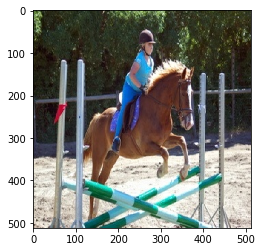

tf.Tensor(
[[[ 0.228125    0.22477064  0.74375     0.98165138 13.        ]
  [ 0.359375    0.08715596  0.559375    0.6559633  15.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0

In [31]:
for data in dataset.take(1):
    plt.imshow(data[0][0])
    plt.show()
    print(data[1])

現在一樣把產生dataset的部份寫成函數

In [32]:
def get_dataset(imgs_name, true_boxes, h, w, batch_size=5, shuffle=3000, seed=10):
    """生成tf.data.Dataset
    執行之前應該先從get_imgs_bounding_box取得照片路徑清單與實際框的資訊
    
    :params: imgs_name: 照片路徑清單
    :params: true_boxes: 照片內的邊界框資訊
    :params: h: 預計resize的照片高度
    :params: w: 預計resize的照片寬度
    :params: batch_size: 每次取批數量，預設為5
    :params: shuffle_num: 打散的數量，預設為3000
    :params: seed: 亂數種子，預設為10
    
    return
        dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((imgs_name, true_boxes))
    # 資料轉型別
    dataset = dataset.map(lambda x, y: img2tensor(x, y, h=h, w=w))
    # 資料打散
    dataset = dataset.shuffle(3000, seed=seed)
    # 資料要重覆
    dataset = dataset.repeat()
    # 設置每批數量
    # 這可以自己利用參數來設置
    dataset = dataset.batch(batch_size)
    # 設置預取
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [33]:
datasets = get_dataset(imgs_name, true_boxes, 512, 512, batch_size=5)

現在，讓我們利用matplotlib來畫出方框，子圖表的定義可以參考[蔽人拙作](https://github.com/shaoeChen/matplotlib/blob/master/Matplotlib_on_python_%E5%AD%90%E5%9C%96%E8%A1%A8%E8%88%87%E5%A4%9A%E5%9C%96%E8%A1%A8%E8%A8%AD%E7%BD%AE.ipynb)

In [34]:
import matplotlib.patches as patches

258.048 178.85866666666666 39.93599999999998 180.22400000000002 13.0
242.688 128.34133333333332 75.77600000000001 161.10933333333335 15.0


<Figure size 1152x648 with 0 Axes>

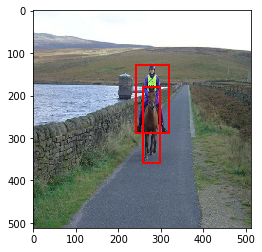

In [56]:
for data in datasets.take(1):    
    fig = plt.figure(figsize=(16, 9))
    img = data[0][0]    
    f, ax = plt.subplots(1, 1)
    ax.imshow(img)
    objects = data[1][0]
    # 一張照片上可能有多個物件，因此要迴圈處理    
    for idx in range(objects.shape[0]):
        obj = objects[idx]
        if obj[-1] == 0.:
            # 沒物件的時候就直接中斷迴圈
            break        
        # tensor to numpy
        box = obj.numpy()
        # 剛剛我們將座標點標準化，現在我們要將它還原為resize之後的照片大小
        x = box[0] * 512
        y = box[1] * 512
        w = (box[2] * 512) - (box[0] * 512)
        h = (box[3] * 512) - (box[1] * 512)
        label = box[4]
        
        # 畫方框
        rect = patches.Rectangle((x, y), 
                                 w, 
                                 h, 
                                 linewidth=2, 
                                 facecolor='none', 
                                 edgecolor='red')    
        print(x, y, w, h, label)
        ax.add_patch(rect)
        
plt.show()

一樣的，我們可以把這個繪圖出來確認的部份函數化

In [36]:
import matplotlib.patches as patches

def plot_dataset(datasets, h, w):
    """隨機取一張照片出來繪製
    
    請先利用get_dataset取得dataset
    
    :params: datasets: 從get_dataset取得的dataset
    :params: h: 預計resize的照片高度
    :params: w: 預計resize的照片寬度
    """
    for data in datasets.take(1):
        fig = plt.figure(figsize=(16, 9))
        img = data[0][0]    
        f, ax = plt.subplots(1, 1)
        ax.imshow(img)
        objects = data[1][0]
        # 一張照片上可能有多個物件，因此要迴圈處理    
        for idx in range(objects.shape[0]):
            obj = objects[idx]
            if obj[-1] == 0.:
                # 沒物件的時候就直接中斷迴圈
                break        
            # tensor to numpy
            box = obj.numpy()
            x = box[0] * w
            y = box[1] * h
            w = (box[2] * w) - (box[0] * w)
            h = (box[3] * h) - (box[1] * h)
            label = box[4]

            # 畫方框
            rect = patches.Rectangle((x, y), 
                                     w, 
                                     h, 
                                     linewidth=2, 
                                     facecolor='none', 
                                     edgecolor='red')    
            print(x, y, w, h, label)
            ax.add_patch(rect)
        
        plt.show()
        # 只需要一張，因此一次迭代就中斷
        break
    

測試一下效果

62.464 105.80522565320665 376.832 319.8479809976247 7.0


<Figure size 1152x648 with 0 Axes>

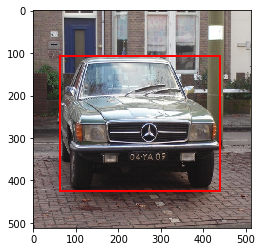

In [37]:
plot_dataset(datasets, 512, 512)

一定要注意到，照片大大小小，過程中我們需要特別注意的就是維度的問題。如果座標點沒有做這個標準化動作，那你一次只能取一張，如果取多張就會造成維度異常。到這邊我們已經有一個資料的生成器(雖然不是真的生成器)，還可以隨機繪製一張圖來確認我們的資料取得狀況。

在[參考連結jmpap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0/blob/master/Yolo_V2_tf_2.ipynb)中有另外再處理資料增強的部份，他所使用的是imgaug 這個套件，看起來不錯，有機會可以試一下。

在成功建立dataset來生成資料之後，我們要繼續下一步，也就是將資料格式轉為YOLOv2訓練格式。是的，還沒有結束，我們只是成功的建立一個資料生成器來批次取出資料而以，接下來要將資料轉為訓練過程中需求的格式。

我們在論文中知道，作者利用`k=5`來取得5個先驗框，因此我們要先定義5個先驗框

In [41]:
# 先驗框的寬與高
anchors = [1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071]        
anchors = np.array(anchors)
anchors = anchors.reshape(-1,2)

In [42]:
anchors.shape

(5, 2)

我們已經建立5個先驗框的寬、高資訊，接下來我們要知道的是，YOLO會將照片切割為grid，然後每一個cell會有5個anchor box，每個anchor box會有5個座標+20個類別，grid的計算就是以input shape/32來計算，32的倍數，因此論文最終的input是418x418，這意味著它會將影像切割成13x13，如果是512x512的話，就是16x16...以此類推。

我們現在用的是512x512，因此我們會將影像切割成16x16

In [43]:
grid_hw = 512  /32
print(grid_hw)

16.0


上面，我們的dataset的batch_size設置為5，我們要開一個matrix來記錄物件存在於那一個cell，維度為batch_size, grid_h, grid_w, anchor_num, 1，存在物件的anchor則賦值為1

In [113]:
detector_mask = np.zeros([5, 16, 16, 5, 1])
print(detector_mask.shape)

(5, 16, 16, 5, 1)


然後再定義一個matrix要記錄最佳anchor box的記錄，其維度為batch_size, grid_h, grid_w, anchor_num, box_info(5)，記錄中心座標(x, y)、寬、高以及類別

In [114]:
y_true_anchor_boxes = np.zeros([5, 16, 16, 5, 5])
print(y_true_anchor_boxes.shape)

(5, 16, 16, 5, 5)


然後再定義一個matrix要記錄最佳anchor box內的class one hot，因此維度為batch_size, grid_h, grid_w, anchor_num, class_num

In [115]:
y_true_class_hot = np.zeros([5, 16, 16, 5, 20])
print(y_true_class_hot.shape)

(5, 16, 16, 5, 20)


然後再定義一個matrix要記錄照片的寬、高、中心點，要注意到的是，這邊的寬、高、中心點會依grid來縮放，而且因為我們在處理資料集的時候已經考慮照片的大小，因此這邊不再考慮照片的大小。

In [116]:
y_true_boxes_all = np.zeros([5, 42, 5]) # 我們的資料集最多取到42個框

接下來，我們需要一個迴圈來看這個batch_size裡面的所有東西，在這個範例的batch_size=5，我們直接帶入

In [117]:
# 取1個batch size的資料，也就是5筆
for data in datasets.take(1):
    for i in range(5):
        # 邊界框的資訊先轉為numpy
        boxes = data[1][i].numpy()
        # 遍歷所有的邊界框
        for idx, box in enumerate(boxes):
            # 沒有物件的時候就直接中斷
            if box[4] == 0:
                break
            # 計算寬、高
            w = box[2] - box[0]
            h = box[3] - box[1]
            # 取得中心點
            cx = (box[0] + box[2]) / 2
            cy = (box[1] + box[3]) / 2
            #print(f'before norm: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
    
            # 根據grid的h, w來縮放
            # 我們已經有先做過縮放，因此這邊不會再考慮照片大小
            # 但實際上我們是將座標值/512*16
            w *= 16
            h *= 16
            cx *= 16
            cy *= 16
            #print(f'after norm: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
            
            # 記錄這個batch的第i筆資料的第j個邊界框資訊            
            y_true_boxes_all[i, idx] =  np.array([cx, cy, w, h, box[4]])
            
            # 接著，我們要計算中心點是落在那一個cell
            # 我們以grid來縮放，因此直接取整數就可以知道它是落在那一個grid
            # 舉例來說，512x512的中心點是256, 256，我們以img大小來縮放，它就是0.5, 0.5
            # 再以grid來縮放0.5 * 16 = 8，也就是中心點在grid裡面是8, 8
            # 畫個圖簡單勾稽一下就可以理解
            cell_col = np.floor(cx).astype(np.int)
            cell_row = np.floor(cy).astype(np.int)                                
            print(f'cell col: {cell_col}, cell row: {cell_row}')
            
            # 現在我們要找出擁有最高iou的那個anchor box
            # 參考的其中一位作者利用迴圈來處理，但是在numpy裡面就會自動bordercast
            # 因此不需要再利用迴圈，這可以提高效能
            # 取出anchor box的寬與高
            anchors_w = anchors[:, 0] 
            anchors_h = anchors[:, 1]             
            # 首先計算交集的面積
            intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
            print(f'intersect: {intersect}')
            # 接著計算聯集的區域面積
            # 兩個面積相加再減掉交集的面積
            union = (anchors_w * anchors_h) + (w * h) - intersect
            print(f'union: {union}')
            # 計算iou
            iou = intersect / union
            print(f'iou: {iou}')
            
            anchor_best = np.max(iou)
            # 最大iou的index
            anchor_best_idx = np.argmax(iou) 
            print(f'best anchor: {anchor_best}')
            print(f'best anchor idx: {anchor_best_idx}')
            
            # 記錄產品類別
            cls_idx = int(box[4])
            
            # 將最佳anchor box的記錄下來
            detector_mask[i, cell_col, cell_row, anchor_best_idx] = 1      
            # 這意味著我們在第cell_row的第cell_col中的第anchor_best_idx記錄座標資訊
            y_true_anchor_boxes[i, cell_col, cell_row, anchor_best_idx] = [cx, cy, w, h, cls_idx]
            # 在正確的anchor box中的類別賦值1
            y_true_class_hot[i, cell_col, cell_row, anchor_best_idx, cls_idx - 1] = 1
        
    # 迴圈結束之後，我們要將numpy array轉tensor
    detector_mask = tf.convert_to_tensor(detector_mask, dtype='int64')
    y_true_anchor_boxes = tf.convert_to_tensor(y_true_anchor_boxes, dtype='float32')
    y_true_boxes_all = tf.convert_to_tensor(y_true_boxes_all, dtype='float32')
    batch = (x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all)        
    print(detector_mask.shape, y_true_anchor_boxes.shape, y_true_boxes_all.shape, y_true_class_hot.shape)


cell col: 5, cell row: 9
intersect: [ 2.28915004 12.80113956 38.61336448 32.21856768 50.83409067]
union: [ 50.83409067  50.83409067  53.16781285  64.46076348 112.44377844]
iou: [0.04503179 0.25182194 0.72625452 0.49981672 0.45208451]
best anchor: 0.7262545215291912
best anchor idx: 2
cell col: 6, cell row: 9
intersect: [ 2.28915004 12.80113956 31.61818368 18.89742912 35.979264  ]
union: [ 35.979264    35.979264    45.30816698  62.92707537 112.44377844]
iou: [0.06362415 0.35579215 0.69784734 0.30030681 0.31997559]
best anchor: 0.6978473371848789
best anchor idx: 2
cell col: 7, cell row: 7
intersect: [  2.28915004  12.80113956  40.94708666  45.84524049 112.44377844]
union: [157.28366933 157.28366933 157.28366933 157.28366933 157.28366933]
iou: [0.01455428 0.08138887 0.26033909 0.29148125 0.7149107 ]
best anchor: 0.7149107018968156
best anchor idx: 4
cell col: 8, cell row: 9
intersect: [  2.28915004  12.80113956  40.94708666  45.84524049 112.44377844]
union: [196.784128 196.784128 196.784

我們來檢查一下資料是否正確寫入

下面檢查第一張照片的第五個row、第九個column的第二個anchor box的索引是否為1

In [118]:
detector_mask[0][5][9]

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [0],
       [1],
       [0],
       [0]])>

一樣的，我們將這個部份函數化，方便後續的使用

In [128]:
def data2yolo(x, y, cfg):
    """將dataset轉為yolo訓練格式
    
    params:
        x: 輸入影像，一次一batch，因此維度為batch_size, h, w, 3
        y: 相關標記資料，其維度為batch_size, 最大框數量, 5，5所指為四點座標以及類別
        cfg: 參數的實作類別，避免函數參數過多
        
    return:
        detector_mask: 記錄物件存在於那一個cell，維度為batch_size, grid_h, grid_w, anchor_num, 1，存在物件的anchor則賦值為1
        y_true_anchor_boxes: 記錄最佳anchor box的記錄
                             其維度為batch_size, grid_h, grid_w, anchor_num, box_info(5)，記錄中心座標(x, y)、寬、高以及類別
        y_true_class_hot: 記錄最佳anchor box內的class one hot，因此維度為batch_size, grid_h, grid_w, anchor_num, class_num
        y_true_boxes_all: 記錄照片的寬、高、中心點，要注意到的是，這邊的寬、高、中心點會依grid來縮放 
                          因為我們在處理資料集的時候已經考慮照片的大小，因此這邊不再考慮照片的大小
    """
    # 先驗手設的anchor
    anchors = cfg.ANCHORS
    # 取得先驗anchor的數量，範例為5，論文也為5
    num_anchors = anchors.shape[0]
    
    # 資料格式轉為numpy
#     y = y.numpy()
    batch_size = y.shape[0]
    
    # 定義四個matrix
    # 記錄物件存在於那一個cell，維度為batch_size, grid_h, grid_w, anchor_num, 1，存在物件的anchor則賦值為1
    detector_mask = np.zeros([batch_size, cfg.GRID_W, cfg.GRID_H, num_anchors, 1])
    # 記錄最佳anchor box的記錄，其維度為batch_size, grid_h, grid_w, anchor_num, box_info(5)，記錄中心座標(x, y)、寬、高以及類別
    y_true_anchor_boxes = np.zeros([batch_size, cfg.GRID_W, cfg.GRID_H, num_anchors, 5])
    # 記錄最佳anchor box內的class one hot，因此維度為batch_size, grid_h, grid_w, anchor_num, class_num
    y_true_class_hot = np.zeros([batch_size, cfg.GRID_W, cfg.GRID_H, num_anchors, cfg.NUM_CLASSES])
    # 記錄照片的寬、高、中心點，要注意到的是，這邊的寬、高、中心點會依grid來縮放
    # 因為我們在處理資料集的時候已經考慮照片的大小，因此這邊不再考慮照片的大小
    y_true_boxes_all = np.zeros(y.shape) # 我們的資料集最多取到42個框
    
    # 迴圈處理batch_size內的所有資料
    for i in range(batch_size):
        # 邊界框的資訊先轉為numpy
        boxes = data[1][i].numpy()
        # 遍歷所有的邊界框
        for idx, box in enumerate(boxes):
            # 沒有物件的時候就直接中斷
            if box[4] == 0:
                break
            # 計算寬、高
            w = box[2] - box[0]
            h = box[3] - box[1]
            # 取得中心點
            cx = (box[0] + box[2]) / 2
            cy = (box[1] + box[3]) / 2
            #print(f'before norm: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
    
            # 根據grid的h, w來縮放
            # 我們已經有先做過縮放，因此這邊不會再考慮照片大小
            # 但實際上我們是將座標值/512*16
            w *= cfg.GRID_W
            h *= cfg.GRID_H
            cx *= cfg.GRID_W
            cy *= cfg.GRID_H
            #print(f'after norm: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
            
            # 記錄這個batch的第i筆資料的第j個邊界框資訊            
            y_true_boxes_all[i, idx] =  np.array([cx, cy, w, h, box[4]])
            
            # 接著，我們要計算中心點是落在那一個cell
            # 我們以grid來縮放，因此直接取整數就可以知道它是落在那一個grid
            # 舉例來說，512x512的中心點是256, 256，我們以img大小來縮放，它就是0.5, 0.5
            # 再以grid來縮放0.5 * 16 = 8，也就是中心點在grid裡面是8, 8
            # 畫個圖簡單勾稽一下就可以理解
            cell_col = np.floor(cx).astype(np.int)
            cell_row = np.floor(cy).astype(np.int)                                
            print(f'cell col: {cell_col}, cell row: {cell_row}')
            
            # 現在我們要找出擁有最高iou的那個anchor box
            # 參考的其中一位作者利用迴圈來處理，但是在numpy裡面就會自動bordercast
            # 因此不需要再利用迴圈，這可以提高效能
            # 取出anchor box的寬與高
            anchors_w = anchors[:, 0] 
            anchors_h = anchors[:, 1]             
            # 首先計算交集的面積
            intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
            print(f'intersect: {intersect}')
            # 接著計算聯集的區域面積
            # 兩個面積相加再減掉交集的面積
            union = (anchors_w * anchors_h) + (w * h) - intersect
            print(f'union: {union}')
            # 計算iou
            iou = intersect / union
            print(f'iou: {iou}')
            
            anchor_best = np.max(iou)
            # 最大iou的index
            anchor_best_idx = np.argmax(iou) 
            print(f'best anchor: {anchor_best}')
            print(f'best anchor idx: {anchor_best_idx}')
            
            # 記錄產品類別
            cls_idx = int(box[4])
            
            # 將最佳anchor box的記錄下來
            detector_mask[i, cell_col, cell_row, anchor_best_idx] = 1      
            # 這意味著我們在第cell_row的第cell_col中的第anchor_best_idx記錄座標資訊
            y_true_anchor_boxes[i, cell_col, cell_row, anchor_best_idx] = [cx, cy, w, h, cls_idx]
            # 在正確的anchor box中的類別賦值1
            y_true_class_hot[i, cell_col, cell_row, anchor_best_idx, cls_idx - 1] = 1
            
    # 迴圈結束之後，我們要將numpy array轉tensor
    detector_mask = tf.convert_to_tensor(detector_mask, dtype='int64')
    y_true_anchor_boxes = tf.convert_to_tensor(y_true_anchor_boxes, dtype='float32')
    y_true_boxes_all = tf.convert_to_tensor(y_true_boxes_all, dtype='float32')
    batch = (x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all)        
    # 或者你也可以yield batch
    return batch

好了，我們來測試一下這個函數是否正常執行，在那之前我們要先定義一個設置參數的類別，這後續建置模型的時候一樣會用到

In [129]:
class Config():
    def __init__(self):
        # 先驗anchor box的寬與高
        self.ANCHORS = [1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071]        
        self.ANCHORS = np.array(self.ANCHORS)
        self.ANCHORS = self.ANCHORS.reshape(-1,2)
        # 我們還將輸入影像縮小為416x416，而不是448x448。這麼做是因為我們希望feature map內的位置數量是奇數，因此只會有一個中心單元
        self.IMAGE_W = 512
        self.IMAGE_H = 512
        # 使用416x416的輸入影像會得到feature map 13x13的輸出
        # 416/32 = 13，代表我們會將照片切成13x13
        self.GRID_W = 16
        self.GRID_H = 16
        self.NUM_ANCHORS = 5
        self.NUM_CLASSES = 20
        self.LAMBDA_NOOBJECT  = 1
        self.LAMBDA_OBJECT    = 5
        self.LAMBDA_CLASS     = 1
        self.LAMBDA_COORD     = 1

In [130]:
cfg = Config()

In [131]:
batch = None
for data in datasets.take(1):
    boxes = data[1]
    imgs = data[0]
    batch = data2yolo(imgs, boxes, cfg)

cell col: 4, cell row: 8
intersect: [ 2.28915004 12.80113956 40.94708666 39.77084108 76.50940541]
union: [ 76.50940541  76.50940541  76.50940541  82.58380482 112.44377844]
iou: [0.02991985 0.16731459 0.53519024 0.4815816  0.68042364]
best anchor: 0.6804236434142137
best anchor idx: 4
cell col: 4, cell row: 11
intersect: [ 2.28915004 12.80113956 40.77053568 33.02607856 55.01924324]
union: [ 55.01924324  55.01924324  55.19579422  67.83840518 112.44377844]
iou: [0.04160635 0.23266659 0.73865294 0.48683454 0.48930447]
best anchor: 0.7386529400194017
best anchor idx: 2
cell col: 8, cell row: 12
intersect: [ 2.28915004 12.80113956 35.37760768 45.84524049 78.62483627]
union: [108.59861333 108.59861333 114.16809231 108.59861333 142.41755551]
iou: [0.021079   0.11787572 0.30987299 0.42215309 0.55207264]
best anchor: 0.5520726429192656
best anchor idx: 4
cell col: 1, cell row: 10
intersect: [ 2.28915004 12.80113956 28.5081984  17.0386656  30.93845333]
union: [ 30.93845333  30.93845333  43.377341

嗯，忘了將debug的print弄掉，不過也確定我們的函數是正常運作。

到這邊，我們真正準備好訓練YOLOv2所需要的資料格式以及函數，總結來看我們做了那些事：
* 設置一個function來parser xml，從裡面取得我們需要的基本資訊
* 設置一個function來生成tf的dataset，這讓我們可以從parser的資料中取得需求資料
* 設置一個function從dataset中取得資料並轉為訓練格式的資料

整個過程，我們都在處理資料，要知道的是，訓練一個模型重要的不單單是模型的架構，還有資料的前置預處理。雖然有直接的api可以使用，但是自己手動怒寫一波之後，後面有變化的案子我們就可以用現有的基礎小調之後就可以產生符合的資料格式。

不過，有機會我想還是可以試著用一下人家寫好的function，有時候一鍵完成的感覺也是很不錯。